# **Assignment 2**

In [212]:
%matplotlib inline
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
import pandas_profiling
import sklearn



# **1. Big Picture**

# **2. Get The Data**

In [213]:
train_data = pd.read_csv(r'C:\GitRepos\ML\Assignment3_ML\ELL_with_flask\\train.csv')
train_copy = train_data.copy()



# **3. Explore the data to gain insights**

In [214]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


The third entry shows \n has been used for newline. Lets fix this using regex so it does not interfere with our analysis.

In [215]:
train_copy['full_text'] = train_copy['full_text'].replace(r'\n',' ', regex=True).replace(r'\r',' ', regex=True).replace(r'\\', ' ', regex=True)

In [216]:
train_copy.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [217]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


array([[<AxesSubplot:title={'center':'cohesion'}>,
        <AxesSubplot:title={'center':'syntax'}>],
       [<AxesSubplot:title={'center':'vocabulary'}>,
        <AxesSubplot:title={'center':'phraseology'}>],
       [<AxesSubplot:title={'center':'grammar'}>,
        <AxesSubplot:title={'center':'conventions'}>]], dtype=object)

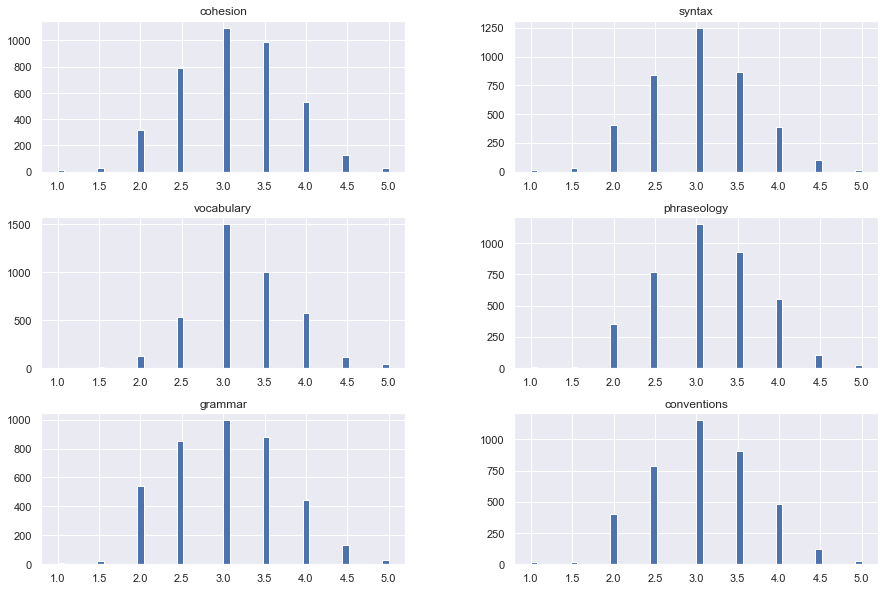

In [218]:
train_copy.hist(bins=50, figsize=(15,10))

nevne om at er 6 target values

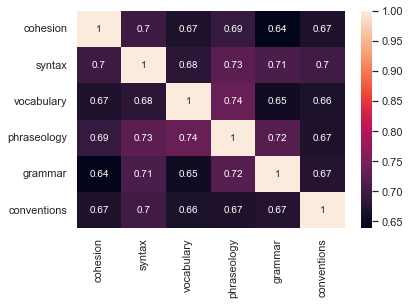

In [219]:
sns.heatmap(train_copy.corr(), annot =True )
sns.set(rc = {'figure.figsize':(15,15)})
plt.show()

#  **4. Prepare the data to better expose the underlying data patterns to machine learning algorithms**

## **The approach**

Machine learning models can't "read" the text in the same way us humans can.
I'll have to create new features that represent the text in a format the algorithm can understand.

Presumably the best way to start is to add a "length" feature. I'll be using this so the algorithm does not dsicriminate based of length of an essay.
A human can easily say 1 grammatical mistake in 10 words is more severe than 2 mistakes in 100 words, the algorithm does not *necessarily* know this.

We don't actually know if the essays vary much in size, but it's only one way to find out.

In [220]:
train_copy['length'] = train_copy['full_text'].str.len()
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326


In [221]:
print(train_copy['length'].min())
print(train_copy['length'].max())

82
6044


Turns out the longest essay is nearly 100 times longer than the shortest. This information is clearly useful, atleast for further feature engineering.

The features added from now on will mostly be trial and error. I am obviously no expert on linguistics, and the features added will be based on gut feelings. Trying different parameters, and seing what sticks. Mostly based of feature importance.

It is difficult for me to tell what features matter more to the different labels.
The final solution will be training one final model for each label, where all of them have the same features.

These are some points/thoughts I will try to base my features off:
- Long sentences are often hard to understand/follow.
- Punctuation:
    - Frequency, relates to point above. The longer the sentence, the harder it becomes to follow.

- Grammatical/spelling errors
    - A well written texts seems less likely to include.
    - Different grammatical mistakes

- Vocabulary:
    - What words - what frequency.
    - Length of words
    
- Length of text could be an important feature for accuracy in the training set, but should not be used. We want the algorithm to rate the quality of the text independently of the length.

I will go through this list iteratively.
All features will be added in relation to length (number of characters) of essay. (**Frequency**)

Before we do any feature engineering. Lets extract a set evaluation data from our training data. 

In [222]:
from sklearn.model_selection import train_test_split

In [223]:
from collections import Counter

##Function for finding frequency of chars in text. 
def frequencyChars(text, char):

    ##Creates counter - dictionary of (char, number of occurences)
    count = Counter(text)


    char_occ = count.get(char)

    ##In case char is not in text
    if char_occ is None:

        char_occ = 0
        
    ##Returns frequency of char in text    
    return char_occ/len(text)

I will be using a python language tool. This is an open-source spelling/grammar checker. It finds errors and has a class called match. For each error, an instance of match is created. It has variables for "error-type", "issueCategory", "ruleId" and more. I'll be using this for the feature engineering. Used overview of all rules found here https://community.languagetool.org/rule/list?offset=0&max=10&lang=en&filter=&categoryFilter=&_action_list=Filter. 

In [224]:
##pip install language-tool-python
import language_tool_python  

##Creates instance of checker object. Was practically unusable before enabling pipelining, cut running time by two digit factor. 
checker = language_tool_python.LanguageTool('en-US', config={ 'cacheSize': 1000, 'pipelineCaching': True, 'maxSpellingSuggestions':0})


##Takes text (string) and instance of LanguageTool as input. Returns list of Match instances.
def allErrors(text, checker):
    return checker.check(text)

CalledProcessError: Command '['C:\\Program Files (x86)\\Common Files\\Oracle\\Java\\javapath\\java.exe', '-version']' returned non-zero exit status 1.

In [ ]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326


In [ ]:
##Makes errors column. List of matches for each text.
train_copy['errors'] = train_copy.apply(lambda x: allErrors(x['full_text'], checker),  axis = 1)

## **Long Sentences/Punctuation**

As stated earlier: long sentences are often hard to understand/follow.
Line below defines sentence length as frequency of periods.
This is not a perfect solution.
Dates are sometimes expressed with periods (17.04.2000, 17th of April).
Periods are used more in written dialouge.
Could be more because of typos aswell.

In [ ]:
train_copy['F_period/Sentence_length'] = train_copy.apply(lambda x: frequencyChars(x['full_text'], '.'),  axis = 1)

## **Grammatical/Spelling errors**

Frequency of grammatical/spelling error seems the most important for the predictions. It is intuitive that all the labels are affected by mistakes, though probably some more than others. 

### **Spelling**

The three functions below are the same, except they filter matches by different variables (ruleId, issueType, category).
The functions are constructed so that they could filter on multiple variables of the same type of variable.

In [ ]:
##Takes list of match-instances and ruleIds as arguments
# returns list of all instances that match ruleId 
def matchesByRules(matches, ruleIds):
    
    ##Creates empty list with given length (number of matches). Can't append match instance to list. So did this instead
    applicable = [None] * len(matches)

    ##Used for shortening list afterwards
    numberApplicable = 0

    ##Checks every match
    for match in matches:

        if match.ruleId in ruleIds:
            applicable[numberApplicable] = match
            numberApplicable += 1
    
    ##Returns empty list or list with matches         
    return applicable[:numberApplicable]

def matchesByIssueType(matches, issueTypes):

    applicable = [None] * len(matches)
    numberApplicable = 0

    for match in matches:

        if match.ruleIssueType in issueTypes:
            applicable[numberApplicable] = match
            numberApplicable += 1
            
    return applicable[:numberApplicable]

def matchesByCategory(matches, categories):

    applicable = [None] * len(matches)
    numberApplicable = 0

    for match in matches:

        if match.category in categories:
            applicable[numberApplicable] = match
            numberApplicable += 1
            
    return applicable[:numberApplicable]

Adds error columns for punctuation (category), spelling (issueType) and casing (category).
Adds frequency for the ones mentioned above and errors.

In [ ]:
#Finds frequency of errors
train_copy['F_errors'] = train_copy.apply(lambda x: len(x['errors'])/x['length'], axis=1)

##criteria
punctuation_category = ['PUNCTUATION']

train_copy['punctuation_errors'] = train_copy.apply(lambda x: matchesByCategory(x['errors'], punctuation_category), axis=1)
train_copy['F_punctuation_errors'] = train_copy.apply(lambda x: len(x['punctuation_errors'])/x['length'], axis=1)

##criteria
misspelling_ruleIssueType = ['misspelling']

train_copy['spelling_errors'] = train_copy.apply(lambda x: matchesByIssueType(x['errors'], misspelling_ruleIssueType),  axis = 1)
train_copy['F_spelling_errors'] = train_copy.apply(lambda x: len(x['spelling_errors'])/x['length'], axis=1)

##criteria
casing_category = ['CASING']

train_copy['casing_errors'] = train_copy.apply(lambda x: matchesByCategory(x['errors'], casing_category),  axis = 1)
train_copy['F_casing_errors'] = train_copy.apply(lambda x: len(x['casing_errors'])/x['length'], axis=1)


### **Grammatical**

Collecting all errors of issueType grammar and assigning to new column.
Calculating frequency of said errors.

In [ ]:
grammar_ruleIssueType = ['grammar']

train_copy['grammar_errors'] = train_copy.apply(lambda x: matchesByIssueType(x['errors'], grammar_ruleIssueType),  axis = 1)
train_copy['F_grammar_errors'] = train_copy.apply(lambda x: len(x['grammar_errors'])/x['length'], axis=1)

## **Vocabulary**

### **Length of words**

The length of words is worth investegating. Perhaps good writers are conscise and use shorter words, or perhaps they use longer more descriptive ones?

In [ ]:
##Function removes 
def numbWords(text):
    
    text = text.translate(str.maketrans(' ', ' ', string.punctuation))
    text = text.split()

    return len(text)

In [ ]:
train_copy['word_Density'] = train_copy.apply(lambda x: numbWords(x['full_text'])/x['length'], axis=1)

NameError: name 'string' is not defined

## **Sum of metrics**

The labels are all highly correlated. Looking at the rows the labels mostly vary within a range of 0.5 to 1.5.
Could be worth a try to predict the mean first, then give this as a feature for the independent label models.

In [ ]:
labels = ['cohesion',	'syntax','vocabulary',	'phraseology',	'grammar', 'conventions']
train_copy['average'] = train_copy.loc[0:, labels].sum(axis=1)/len(labels)

# **5. Explore many different models and short-list the best ones**

For trying different models I've decided to use pycaret.
Pycaret trains different models and compares their scores.

In [ ]:
import pycaret
from pycaret.regression import *

In [ ]:
labels = ['cohesion',	'syntax','vocabulary',	'phraseology',	'grammar', 'conventions']
##train_copy['average'] = train_copy.loc[0:, labels].sum(axis=1)/len(labels)

In [ ]:
train_copy.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,length,errors,...,punctuation_errors,F_punctuation_errors,spelling_errors,F_spelling_errors,casing_errors,F_casing_errors,grammar_errors,F_grammar_errors,word_Density,average
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1387,"[Offset 57, length 8, Rule ID: COMMA_PARENTHES...",...,"[Offset 1342, length 4, Rule ID: COMMA_COMPOUN...",0.000721,"[Offset 71, length 4, Rule ID: WONT_CONTRACTIO...",0.005768,"[Offset 152, length 6, Rule ID: UPPERCASE_SENT...",0.010815,"[Offset 864, length 5, Rule ID: CAUSE_BECAUSE\...",0.001442,0.188176,3.333333
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,2635,"[Offset 118, length 9, Rule ID: UPPERCASE_SENT...",...,"[Offset 1246, length 4, Rule ID: COMMA_COMPOUN...",0.001518,"[Offset 244, length 10, Rule ID: ALONG_TIME\nM...",0.009108,"[Offset 118, length 9, Rule ID: UPPERCASE_SENT...",0.001518,"[Offset 1193, length 16, Rule ID: A_NNS\nMessa...",0.003036,0.202277,2.416667
2,00299B378633,"Dear, Principal If u change the school policy...",3.0,3.5,3.0,3.0,3.0,2.5,1663,"[Offset 15, length 2, Rule ID: WHITESPACE_RULE...",...,"[Offset 1296, length 4, Rule ID: COMMA_COMPOUN...",0.001203,"[Offset 152, length 4, Rule ID: CANT\nMessage:...",0.003608,[],0.000000,"[Offset 1406, length 6, Rule ID: TO_NON_BASE\n...",0.000601,0.192423,3.000000
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,3973,"[Offset 225, length 10, Rule ID: SHORT_COMPARA...",...,"[Offset 1284, length 6, Rule ID: THE_JJR_THE_M...",0.001762,"[Offset 2937, length 5, Rule ID: OTHER_OTHERS\...",0.000503,[],0.000000,"[Offset 225, length 10, Rule ID: SHORT_COMPARA...",0.000252,0.182985,4.500000
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,1326,"[Offset 118, length 7, Rule ID: MORFOLOGIK_RUL...",...,"[Offset 318, length 3, Rule ID: COMMA_COMPOUND...",0.001508,"[Offset 118, length 7, Rule ID: MORFOLOGIK_RUL...",0.009804,[],0.000000,"[Offset 285, length 2, Rule ID: PEOPLE_VBZ\nMe...",0.001508,0.176471,2.750000


In [ ]:
columnsToDrop = ['text_id', 'length', 'full_text', 'errors', 'punctuation_errors', 'spelling_errors', 'casing_errors', 'grammar_errors']
train_copy.drop(columnsToDrop, axis=1, inplace=True)
train_copy.drop(labels, axis=1, inplace=True)

In [ ]:
train_copy.head()

,F_period/Sentence_length,F_errors,F_punctuation_errors,F_spelling_errors,F_casing_errors,F_grammar_errors,word_Density,average
0,0.012978,0.020187,0.000721,0.005768,0.010815,0.001442,0.188176,3.333333
1,0.005313,0.017078,0.001518,0.009108,0.001518,0.003036,0.202277,2.416667
2,0.011425,0.006615,0.001203,0.003608,0.000000,0.000601,0.192423,3.000000
3,0.009061,0.003020,0.001762,0.000503,0.000000,0.000252,0.182985,4.500000
4,0.002262,0.013575,0.001508,0.009804,0.000000,0.001508,0.176471,2.750000


In [ ]:
experiment = setup(data=train_copy, target = labels, normalize=True, normalize_method='robust', session_id=42)

ValueError: X and y don't have the same number of rows, got len(X)=3911 and len(y)=6.

In [ ]:
top4 = compare_models(n_select=4, sort='RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.3282,0.1698,0.4119,0.4546,0.1012,0.1098,0.0940
rf,Random Forest Regressor,0.3339,0.1754,0.4186,0.4374,0.1028,0.1119,0.2290
et,Extra Trees Regressor,0.3367,0.1787,0.4225,0.4263,0.1039,0.1129,0.1340
lightgbm,Light Gradient Boosting Machine,0.3377,0.1815,0.4257,0.4177,0.1045,0.1130,0.1810
ada,AdaBoost Regressor,0.3436,0.1847,0.4294,0.4084,0.1064,0.1174,0.0450
lar,Least Angle Regression,0.3459,0.1904,0.4360,0.3910,0.1095,0.1166,0.0140
br,Bayesian Ridge,0.3459,0.1904,0.4360,0.3910,0.1094,0.1166,0.0150
lr,Linear Regression,0.3459,0.1904,0.4360,0.3910,0.1095,0.1166,1.0340
ridge,Ridge Regression,0.3459,0.1904,0.4360,0.3910,0.1095,0.1166,0.0130
huber,Huber Regressor,0.3458,0.1906,0.4363,0.3902,0.1096,0.1164,0.0150


Processing:   0%|          | 0/80 [00:00<?, ?it/s]

# **6. Fine-tune your models and combine them into a great solution**

In [ ]:
tuned_top4 = [tune_model(i) for i in top4]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3244,0.1665,0.4080,0.4589,0.0987,0.1058
1,0.3364,0.1872,0.4327,0.4155,0.1082,0.1157
2,0.3137,0.1598,0.3997,0.4372,0.0974,0.1038
3,0.3255,0.1680,0.4099,0.4976,0.1020,0.1107
4,0.3216,0.1595,0.3994,0.4661,0.0971,0.1059
5,0.3159,0.1538,0.3922,0.5772,0.0990,0.1101
6,0.3361,0.1782,0.4221,0.4406,0.1008,0.1083
7,0.3302,0.1695,0.4117,0.4225,0.1013,0.1105
8,0.3245,0.1601,0.4001,0.4404,0.0955,0.1038


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3261,0.1658,0.4072,0.4612,0.0990,0.1072
1,0.3302,0.1826,0.4274,0.4299,0.1073,0.1145
2,0.3174,0.1604,0.4005,0.4350,0.0975,0.1047
3,0.3438,0.1867,0.4321,0.4416,0.1093,0.1196
4,0.3307,0.1710,0.4136,0.4276,0.1008,0.1090
5,0.3309,0.1670,0.4086,0.5409,0.1047,0.1171
6,0.3355,0.1767,0.4203,0.4454,0.1003,0.1082
7,0.3259,0.1713,0.4139,0.4165,0.1024,0.1100
8,0.3192,0.1593,0.3992,0.4430,0.0955,0.1023


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3549,0.1982,0.4452,0.3559,0.1073,0.1166
1,0.3624,0.2123,0.4608,0.3372,0.1153,0.1254
2,0.3394,0.1760,0.4195,0.3801,0.1014,0.1110
3,0.3578,0.2059,0.4538,0.3842,0.1143,0.1245
4,0.3547,0.1939,0.4403,0.3512,0.1081,0.1180
5,0.3645,0.2030,0.4505,0.4420,0.1153,0.1298
6,0.3587,0.1959,0.4426,0.3850,0.1066,0.1173
7,0.3346,0.1845,0.4296,0.3715,0.1068,0.1137
8,0.3431,0.1859,0.4311,0.3501,0.1034,0.1109


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3260,0.1696,0.4118,0.4490,0.0997,0.1066
1,0.3271,0.1779,0.4218,0.4446,0.1056,0.1125
2,0.3219,0.1632,0.4040,0.4251,0.0986,0.1062
3,0.3455,0.1884,0.4340,0.4368,0.1099,0.1203
4,0.3264,0.1684,0.4103,0.4365,0.1008,0.1084
5,0.3353,0.1716,0.4143,0.5282,0.1057,0.1183
6,0.3318,0.1769,0.4206,0.4446,0.1007,0.1071
7,0.3321,0.1755,0.4190,0.4021,0.1035,0.1116
8,0.3198,0.1590,0.3988,0.4441,0.0955,0.1028


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
bagged_top4 = [ensemble_model(i) for i in top4]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3190,0.1593,0.3992,0.4822,0.0967,0.1041
1,0.3292,0.1798,0.4241,0.4387,0.1053,0.1126
2,0.3143,0.1602,0.4003,0.4356,0.0977,0.1039
3,0.3283,0.1701,0.4124,0.4914,0.1030,0.1123
4,0.3263,0.1638,0.4048,0.4517,0.0988,0.1079
5,0.3131,0.1494,0.3865,0.5894,0.0974,0.1089
6,0.3314,0.1745,0.4177,0.4523,0.0998,0.1070
7,0.3277,0.1689,0.4110,0.4246,0.1015,0.1101
8,0.3219,0.1621,0.4026,0.4333,0.0960,0.1031


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3259,0.1636,0.4045,0.4682,0.0982,0.1071
1,0.3336,0.1854,0.4305,0.4214,0.1077,0.1152
2,0.3183,0.1620,0.4025,0.4293,0.0981,0.1052
3,0.3350,0.1774,0.4211,0.4697,0.1057,0.1154
4,0.3317,0.1715,0.4142,0.4260,0.1010,0.1094
5,0.3255,0.1600,0.4000,0.5600,0.1013,0.1144
6,0.3381,0.1777,0.4215,0.4422,0.1006,0.1090
7,0.3219,0.1656,0.4070,0.4358,0.1008,0.1086
8,0.3239,0.1669,0.4086,0.4164,0.0978,0.1041


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3299,0.1659,0.4073,0.4608,0.0991,0.1087
1,0.3361,0.1876,0.4331,0.4145,0.1082,0.1161
2,0.3196,0.1633,0.4042,0.4247,0.0984,0.1057
3,0.3320,0.1775,0.4213,0.4693,0.1060,0.1148
4,0.3355,0.1731,0.4161,0.4206,0.1014,0.1106
5,0.3248,0.1612,0.4014,0.5569,0.1023,0.1146
6,0.3373,0.1776,0.4214,0.4426,0.1006,0.1088
7,0.3242,0.1624,0.4030,0.4468,0.0997,0.1090
8,0.3238,0.1674,0.4091,0.4148,0.0975,0.1038


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3299,0.1681,0.4100,0.4537,0.0997,0.1083
1,0.3412,0.1964,0.4432,0.3869,0.1103,0.1172
2,0.3193,0.1664,0.4080,0.4137,0.0995,0.1051
3,0.3266,0.1677,0.4096,0.4984,0.1025,0.1118
4,0.3264,0.1689,0.4110,0.4348,0.1000,0.1072
5,0.3206,0.1580,0.3975,0.5655,0.1010,0.1124
6,0.3385,0.1816,0.4261,0.4300,0.1016,0.1089
7,0.3302,0.1727,0.4156,0.4118,0.1024,0.1107
8,0.3248,0.1609,0.4012,0.4374,0.0956,0.1037


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
blender = blend_models(estimator_list = top4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3227,0.1605,0.4007,0.4784,0.0971,0.1056
1,0.3385,0.1892,0.4350,0.4094,0.1082,0.1160
2,0.3168,0.1624,0.4030,0.4280,0.0982,0.1046
3,0.3282,0.1706,0.4130,0.4899,0.1034,0.1125
4,0.3297,0.1684,0.4104,0.4365,0.0999,0.1086
5,0.3228,0.1572,0.3965,0.5677,0.1001,0.1128
6,0.3374,0.1777,0.4216,0.4421,0.1006,0.1088
7,0.3265,0.1668,0.4084,0.4319,0.1011,0.1098
8,0.3248,0.1642,0.4052,0.4260,0.0967,0.1042


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
stacked = stack_models(estimator_list = top4)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3227,0.1626,0.4033,0.4716,0.0975,0.1053
1,0.3315,0.1814,0.4259,0.4339,0.1059,0.1135
2,0.3181,0.1628,0.4035,0.4266,0.0984,0.1052
3,0.3317,0.1740,0.4171,0.4797,0.1040,0.1135
4,0.3272,0.1646,0.4058,0.4490,0.0986,0.1078
5,0.3172,0.1568,0.3960,0.5688,0.0996,0.1099
6,0.3321,0.1753,0.4187,0.4498,0.1001,0.1073
7,0.3285,0.1706,0.4130,0.4189,0.1025,0.1105
8,0.3194,0.1615,0.4019,0.4354,0.0959,0.1026


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
best = automl(optimize='RMSE')

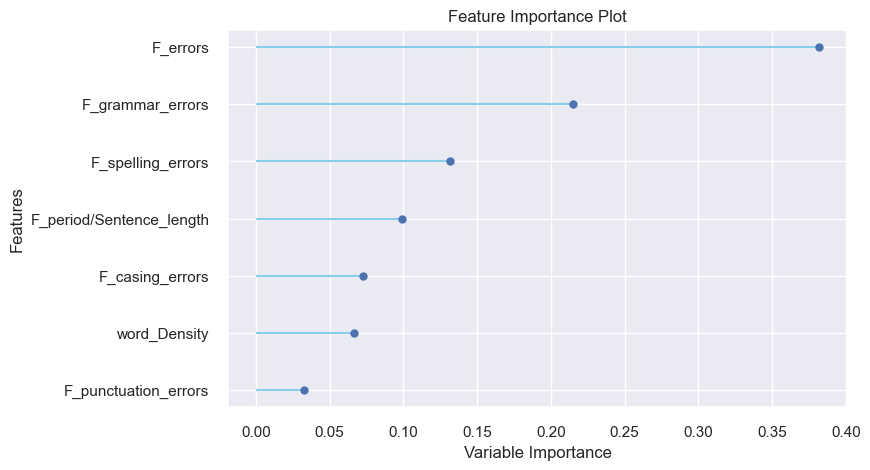

In [ ]:
plot_model(tuned_top4[1], 'feature')

# **7. Present your solution**

# **8. Launch, monitor, and maintain your system**

In [ ]:
'''
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def removeUnwantedChars(df):
    df['full_text'] = df['full_text'].replace(r'\n',' ', regex=True).replace(r'\r',' ', regex=True).replace(r'\\', ' ', regex=True)

def findLength(df):
    df['length'] = np.nan
    df['length'] = df['full_text'].str.len()
    
def findMistakes(df):

    df['errors'] = train_copy.apply(lambda x: allErrors(df['full_text'], checker),  axis = 1)

class ready_data_transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        removeUnwantedChars(X)
        findLength(X)
        findMistakes(X)

        return X




class add_features_tranfsformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        
        return X

pipe = Pipeline(
    steps=[
        ("readyData", ready_data_transformer())
    ]
)
'''

'\nfrom sklearn.base import BaseEstimator, TransformerMixin\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.compose import ColumnTransformer\nfrom sklearn.pipeline import Pipeline\n\ndef removeUnwantedChars(df):\n    df[\'full_text\'] = df[\'full_text\'].replace(r\'\n\',\' \', regex=True).replace(r\'\r\',\' \', regex=True).replace(r\'\\\', \' \', regex=True)\n\ndef findLength(df):\n    df[\'length\'] = np.nan\n    df[\'length\'] = df[\'full_text\'].str.len()\n    \ndef findMistakes(df):\n\n    df[\'errors\'] = train_copy.apply(lambda x: allErrors(df[\'full_text\'], checker),  axis = 1)\n\nclass ready_data_transformer(BaseEstimator, TransformerMixin):\n    \n    def __init__(self):\n        pass\n\n    def fit(self, X, y=None):\n        return self\n\n    def transform(self, X, y=None):\n        \n        removeUnwantedChars(X)\n        findLength(X)\n        findMistakes(X)\n\n        return X\n\n\n\n\nclass add_features_tranfsformer(BaseEstimator, TransformerMixin):\n    \n 